# A computational account of threat-related attentional bias

# Effects of attention on learning

This notebook performs further computational modelling of behaviour using models incorporating effects of eye-tracking derived fixation measures.

In [43]:
import os
import sys
sys.path.insert(0, '../code')

import pymc3 as pm
import pandas as pd
import numpy as np
import os
from DMpy import DMModel, Parameter
from DMpy.utils import beta_response_transform
from modelling_functions import combine_behavioural, save_simulated, plot_param_values
from learning_models import leaky_beta, leaky_beta_asymmetric, leaky_beta_asymmetric_fixation_1, leaky_beta_asymmetric_fixation_2, \
leaky_beta_asymmetric_fixation_1b, leaky_beta_asymmetric_fixation_2b
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.path as path
import matplotlib.font_manager as font_manager
import re
from eyetracking_functions import *
import dill
from tqdm import tqdm

# Random seed
np.random.seed(123)

# Colour palette for plotting
pal = ['#267fd3', '#e88300', '#b21724', '#053c5e']

# Make things look nice
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'


## Load the data

Here we take every subject's behavioural data and combine them into one file with all the necessary information for modelling

In [44]:
eyetracking_dir = r'../data/eye_tracking_data'
behavioural_dir = r'../data/behavioural_data'
combined_data, df = combine_behavioural(behavioural_dir, file_regex='[0-9]{2}_behavioural.+', subject_regex='[0-9]{2}')
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:04<00:00, 15.16it/s]


Excluded subjects: ['24', '31']
Saved combined data to ../data/behavioural_data\uncertainty_attention_shock_combined.csv
Mean shock level = 222.841269841


,Response,Outcome,Outcome_2,Objective_prob_A,Objective_prob_B,Run,Subject
0,0.500000,0.0,1.0,0.2,0.2,0,00
1,0.500000,1.0,0.0,0.2,0.2,0,00
2,0.557183,0.0,0.0,0.2,0.2,0,00
3,0.557183,0.0,0.0,0.2,0.2,0,00
4,0.557183,0.0,0.0,0.2,0.2,0,00


### Eyetracking data

Load in the eye tracking left/right bias data.

In [45]:
eyetracking_data = pd.read_csv(r'outcome_bias_df.csv')
eyetracking_data = eyetracking_data[eyetracking_data['left_proportion'] > 0.2]
eyetracking_data = eyetracking_data[eyetracking_data['right_proportion'] > 0.2]
eyetracking_data = eyetracking_data[eyetracking_data['outside_proportion'] < 0.8]
eyetracking_data = eyetracking_data[eyetracking_data['blink_proportion'] < 0.3]

In [46]:
eyetracking_data.head()

,Unnamed: 0,Subject,trial_number,Outcome_image_L,bias,l_duration,r_duration,l_first_duration,r_first_duration,first_fixation_location,...,A_var,A_True_response,B_var,B_True_response,A_Outcome,B_Outcome,abs_pe_RL_diff,A_pe,B_pe,model_prob_estimate_RL_diff
0,0,11,1,B,0.537854,1.326565,1.543882,0.132294,0.574312,-1.0,...,0.116084,0.500000,0.114683,0.969652,0.0,1.0,-0.200150,-0.500000,0.030348,0.000000
1,1,11,2,B,0.459066,1.418772,1.204047,0.498949,0.324529,-1.0,...,0.149382,0.830443,0.148285,0.969652,0.0,0.0,0.469652,-0.830443,-0.969652,-0.018735
2,2,11,3,B,0.537269,1.744118,2.025066,0.168000,0.314882,-1.0,...,0.177965,0.974808,0.177624,0.973878,0.0,0.0,-0.139209,-0.974808,-0.973878,-0.018542
3,3,11,4,B,0.445225,0.915749,0.734919,0.347462,0.118765,-1.0,...,0.197867,0.139552,0.198736,0.999658,0.0,0.0,0.000930,-0.139552,-0.999658,-0.018200
4,4,11,5,A,0.363265,1.122463,1.967468,0.599941,0.203129,1.0,...,0.206335,0.036434,0.208777,0.747018,0.0,0.0,-0.860106,-0.036434,-0.747018,-0.017595


In [47]:
eyetracking_data.loc[:, 'fix_prop_A'] = eyetracking_data.bias
# eyetracking_data.loc[eyetracking_data['Outcome_image_L'] == 'B', 'fix_prop_A'] = 1 - eyetracking_data.loc[eyetracking_data['Outcome_image_L'] == 'B', 'fix_prop_A']
eyetracking_data.loc[:, 'fix_prop_B'] = 1 - eyetracking_data['fix_prop_A']

In [48]:
eyetracking_data.loc[:, 'fix_dur_A'] = eyetracking_data['l_duration']
eyetracking_data.loc[:, 'fix_dur_B'] = eyetracking_data['l_duration']
eyetracking_data.loc[eyetracking_data['Outcome_image_L'] == 'B', 'fix_dur_A'] = eyetracking_data['r_duration']
eyetracking_data.loc[eyetracking_data['Outcome_image_L'] == 'A', 'fix_dur_B'] = eyetracking_data['r_duration']

### Combine behavioural and eyetracking data

First we remove subjects who were excluded due to poor eyetracking data from behavioural data

In [49]:
eyetracking_data = eyetracking_data[['Subject', 'trial_number', 'fix_prop_A', 'fix_prop_B', 'fix_dur_A', 'fix_dur_B']]
behav_data = df
behav_data.Subject = behav_data.Subject.astype(int)
behav_data = behav_data[behav_data.Subject.isin(eyetracking_data.Subject.unique())].reset_index()

We need the data to be in "long" format - currently we have 160 trials where each trial has data for both stimulus A and B, but we need to instead have 320 trials representing A, B, A, B etc.

In [50]:
eyetracking_data_long_a = pd.melt(eyetracking_data, ['Subject', 'trial_number'], ['fix_prop_A', 'fix_prop_B'], 'Stimulus', 'fixation_proportion_A').sort_values(['Subject', 'Stimulus', 'trial_number'])
eyetracking_data_long_b = pd.melt(eyetracking_data, ['Subject', 'trial_number'], ['fix_dur_A', 'fix_dur_B'], 'Stimulus', 'fixation_duration_A').sort_values(['Subject', 'Stimulus', 'trial_number'])
eyetracking_data_long_a['fixation_duration_A'] = eyetracking_data_long_b['fixation_duration_A']
eyetracking_data_long = eyetracking_data_long_a
eyetracking_data_long['fixation_proportion_B'] = 1 - eyetracking_data_long['fixation_proportion_A']

# eyetracking_data_long = eyetracking_data_long.sort_values(['Subject', 'Stimulus', 'trial_number'])
eyetracking_data_long['Run'] = np.tile(np.hstack([np.repeat(np.arange(0, 8, 2), 40), np.repeat(np.arange(1, 8, 2), 40)]), len(eyetracking_data.Subject.unique()))
eyetracking_data_long = eyetracking_data_long.sort_values(['Subject','Run']).reset_index()

Concatenate the behavioural and eye tracking data and save.

In [51]:
et_behav_data_full = pd.concat([behav_data.reset_index(), eyetracking_data_long[['Stimulus', 'fixation_proportion_A', 'fixation_duration_A', 'fixation_proportion_B']].reset_index()], axis=1)
et_behav_data_full['trial_number'] = np.tile(np.arange(320), len(et_behav_data_full) / 320)

a = np.roll(et_behav_data_full['fixation_duration_A'], -40)
b = np.roll(et_behav_data_full['fixation_duration_A'], 40)
a[(et_behav_data_full['Run'].values % 2).astype(bool)] = b[(et_behav_data_full['Run'].values % 2).astype(bool)]
et_behav_data_full['fixation_duration_B'] = a

# Trials without fixations should be set to zero
et_behav_data_full.loc[et_behav_data_full['fixation_duration_A'].isnull(), 'fixation_duration_A'] = 0
et_behav_data_full.loc[et_behav_data_full['fixation_duration_B'].isnull(), 'fixation_duration_B'] = 0

et_behav_data_full.to_csv('et_behav_data_full.csv')  # Save a version without fixation rolled

For the non-modelling analyses, we're interested in how attention during the outcome phase of the previous trial affects probability estimation on the current trial, so we need to line up the data so each row contains the current trial's behaviour and the previous trial's eye tracking data. Because there's no previous trial for the first trial, we remove the first trial of each block.

In [52]:
et_behav_data = et_behav_data_full.copy()
et_behav_data['fixation_proportion_A'] = np.roll(et_behav_data['fixation_proportion_A'], 1)
et_behav_data['fixation_duration_A'] = np.roll(et_behav_data['fixation_duration_A'], 1)
et_behav_data['fixation_proportion_B'] = np.roll(et_behav_data['fixation_proportion_B'], 1)
et_behav_data['fixation_duration_B'] = np.roll(et_behav_data['fixation_duration_B'], 1)

et_behav_data = et_behav_data[et_behav_data.trial_number % 40 != 0]

et_behav_data.to_csv('et_behav_data.csv')

In [53]:
et_behav_data = pd.read_csv('et_behav_data.csv')
et_behav_data.head()

,Unnamed: 0,level_0,index,Response,Outcome,Outcome_2,Objective_prob_A,Objective_prob_B,Run,Subject,index.1,Stimulus,fixation_proportion_A,fixation_duration_A,fixation_proportion_B,trial_number,fixation_duration_B
0,1,1,1,0.319997,1.0,0.0,0.2,0.2,0,2,1,fix_prop_A,0.725777,1.581651,0.274223,1,0.597600
1,2,2,2,0.515004,0.0,0.0,0.2,0.2,0,2,2,fix_prop_A,0.293573,1.079695,0.706427,2,2.598083
2,3,3,3,0.484996,0.0,0.0,0.2,0.2,0,2,3,fix_prop_A,0.364659,0.826937,0.635341,3,1.440765
3,4,4,4,0.530473,0.0,0.0,0.2,0.2,0,2,4,fix_prop_A,0.310963,0.479364,0.689037,4,1.062180
4,5,5,5,0.530473,0.0,1.0,0.2,0.2,0,2,5,fix_prop_A,0.882846,2.281693,0.117154,5,0.302782


## Is likelihood estimation effected by attention?

First we calculate estimation error - how much subjects over or under-estimate relative to the true probability or receiving a shock from the stimulus.

In [54]:
et_behav_data.loc[:, 'error'] = et_behav_data['Response'] - et_behav_data['Objective_prob_A'] 
et_behav_data.loc[:, 'abs_error'] = np.abs(et_behav_data['error'])

Here we use a hierarchical regression model to predict error from the true value of each stimulus and the proportion of time spent fixating on that stimulus on the previous trial.

In [55]:
n_subjects = len(et_behav_data.Subject.unique())
et_behav_data.loc[:, 'Subject_idx'] = np.arange(n_subjects).repeat(len(et_behav_data) / n_subjects)
subject_idx = et_behav_data.Subject_idx.values

from sklearn.preprocessing import scale
et_behav_data['Objective_prob_A_raw'] = et_behav_data['Objective_prob_A']
et_behav_data[['fixation_proportion_A', 'Objective_prob_A', 'Objective_prob_B', 'Outcome', 'Outcome_2']] = scale(et_behav_data[['fixation_proportion_A', 'Objective_prob_A', 'Objective_prob_B', 'Outcome', 'Outcome_2']])

with pm.Model() as value_fixation_accuracy_model:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value_A = pm.Normal('$\\beta$ Objective probability A $\mu$', mu=0., sd=100**2)
    sigma_b_value_A = pm.HalfCauchy('$\\beta$ Objective probability A $\sigma$', 100)
    mu_b_value_B = pm.Normal('$\\beta$ Objective probability B $\mu$', mu=0., sd=100**2)
    sigma_b_value_B = pm.HalfCauchy('$\\beta$ Objective probability B $\sigma$', 100)
    mu_b_fixation = pm.Normal('$\\beta$ Fixation proportion A $\mu$', mu=0., sd=100**2)
    sigma_b_fixation = pm.HalfCauchy('$\\beta$ Fixation proportion A $\sigma$', 100)
    mu_b_outcome_A = pm.Normal('$\\beta$ Outcome A $\mu$', mu=0., sd=100**2)
    sigma_b_outcome_A = pm.HalfCauchy('$\\beta$ Outcome A $\sigma$', 100)
    mu_b_outcome_B = pm.Normal('$\\beta$ Outcome B $\mu$', mu=0., sd=100**2)
    sigma_b_outcome_B = pm.HalfCauchy('$\\beta$ Outcome B $\sigma$', 100)
    
    # Offsets
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    value_A_offset = pm.Normal('value_A_offset', mu=0, sd=1, shape=n_subjects)
    value_B_offset = pm.Normal('value_B_offset', mu=0, sd=1, shape=n_subjects)
    fixation_offset = pm.Normal('fixation_offset', mu=0, sd=1, shape=n_subjects)
    outcome_A_offset = pm.Normal('outcome_A_offset', mu=0, sd=1, shape=n_subjects)
    outcome_B_offset = pm.Normal('outcome_B_offset', mu=0, sd=1, shape=n_subjects)
       
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)
    b_value_A = pm.Deterministic("b_value_A", mu_b_value_A + value_A_offset * sigma_b_value_A)
    b_value_B = pm.Deterministic("b_value_B", mu_b_value_B + value_B_offset * sigma_b_value_B)
    b_fixation = pm.Deterministic("b_fixation", mu_b_fixation + fixation_offset * sigma_b_fixation)
    b_outcome_A = pm.Deterministic("b_outcome_A", mu_b_outcome_A + outcome_A_offset * sigma_b_outcome_A)
    b_outcome_B = pm.Deterministic("b_outcome_B", mu_b_outcome_B + outcome_B_offset * sigma_b_outcome_B)
    
    # Error
    eps = pm.HalfCauchy('eps', 5)

    # Estimated y values, with logit link function
    y_est = b_intercept[subject_idx] + b_value_A[subject_idx] * et_behav_data['Objective_prob_A'] + \
    b_value_B[subject_idx] * et_behav_data['Objective_prob_B'] + b_fixation[subject_idx] * et_behav_data['fixation_proportion_A'] + \
    b_outcome_A[subject_idx] * et_behav_data['Outcome'] + b_outcome_B[subject_idx] * et_behav_data['Outcome_2']
    
    # Beta likelihood
    y_like = pm.Normal('likelihood', y_est, sd=eps, observed=et_behav_data['error'])

### Fit the model

In [56]:
from pymc3.variational.callbacks import CheckParametersConvergence
with value_fixation_accuracy_model:
    approx = pm.fit(n=80000, random_seed=123)
    trace_outcome_value_fixation_accuracy = pm.sample_approx(approx, draws=1000)

Average Loss = -1,302.3: 100%|██████████████████████████████████████████████████| 80000/80000 [07:43<00:00, 172.71it/s]
Finished [100%]: Average Loss = -1,302.3


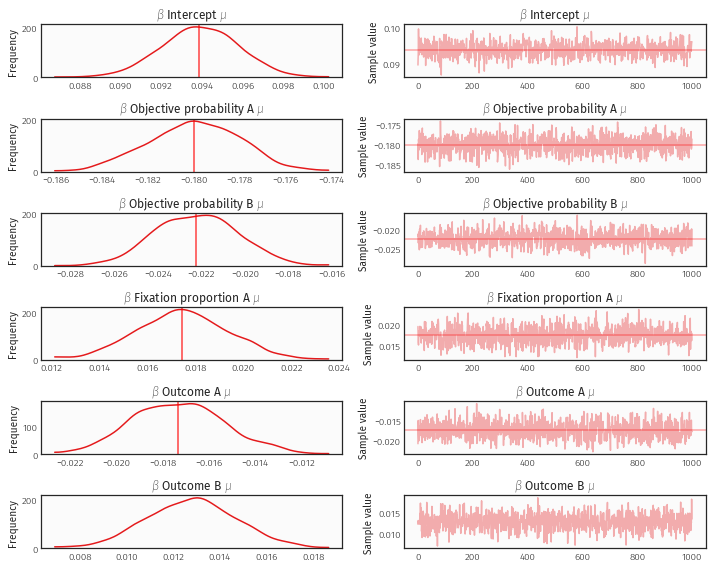

In [57]:
pm.traceplot(trace_outcome_value_fixation_accuracy, lines={'$\\beta$ Intercept $\\mu$':trace_outcome_value_fixation_accuracy['$\\beta$ Intercept $\\mu$'].mean(),
                           '$\\beta$ Objective probability A $\\mu$': trace_outcome_value_fixation_accuracy['$\\beta$ Objective probability A $\\mu$'].mean(),
                           '$\\beta$ Objective probability B $\\mu$': trace_outcome_value_fixation_accuracy['$\\beta$ Objective probability B $\\mu$'].mean(),
                           '$\\beta$ Fixation proportion A $\\mu$': trace_outcome_value_fixation_accuracy['$\\beta$ Fixation proportion A $\\mu$'].mean(),
                           '$\\beta$ Outcome A $\\mu$': trace_outcome_value_fixation_accuracy['$\\beta$ Outcome A $\\mu$'].mean()},
             varnames=['$\\beta$ Intercept $\\mu$', '$\\beta$ Objective probability A $\\mu$', '$\\beta$ Objective probability B $\\mu$',
                      '$\\beta$ Fixation proportion A $\\mu$', '$\\beta$ Outcome A $\\mu$', '$\\beta$ Outcome B $\\mu$'],
             figsize=(10, 8));

In [58]:
full_summary = pm.summary(trace_outcome_value_fixation_accuracy, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Objective probability A $\\mu$', '$\\beta$ Objective probability B $\\mu$',
                      '$\\beta$ Fixation proportion A $\\mu$', '$\\beta$ Outcome A $\\mu$', '$\\beta$ Outcome B $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,0.093878,0.001900,0.000067,0.090037,0.097350
$\beta$ Objective probability A $\mu$,-0.179989,0.001988,0.000062,-0.184122,-0.176528
$\beta$ Objective probability B $\mu$,-0.022241,0.001873,0.000061,-0.025723,-0.018606
$\beta$ Fixation proportion A $\mu$,0.017457,0.001918,0.000064,0.013336,0.020736
$\beta$ Outcome A $\mu$,-0.017330,0.001972,0.000065,-0.020960,-0.013360
$\beta$ Outcome B $\mu$,0.012764,0.001931,0.000061,0.008945,0.016501


This demonstrates that both the true shock probability of the current and other stimulus negatively affects error (so subjects overestimate shock probability to a greater extent when the true shock probability is low), but there is also a small but consistent effect of fixation such that stimuli are assigned a higher shock probability when fixated for longer during the previous outcome phase.

### Plotting probablility mis-estimation

Here we produce an illustrative plot of how subjects mis-estimate shock probabilities for both stable and volatile blocks. This is done by fitting linear models predicting estimation error from true shock probability separately for each type of block, and then plotting regression lines for each subject.

In [59]:
stability_df = et_behav_data.groupby(['Subject', 'Run']).std().reset_index()
stability_df['stable'] = stability_df['Objective_prob_A_raw'] < 0.1
stability_df = stability_df[['Subject', 'Run', 'stable']]
et_behav_data = pd.merge(et_behav_data, stability_df, on=['Subject', 'Run'])

In [60]:
betas = np.zeros((2, 2, len(et_behav_data.Subject.unique())))

for n, sub in enumerate(et_behav_data.Subject.unique()):
    stable_df = et_behav_data[(et_behav_data.Subject == sub) & (et_behav_data.stable == True)]
    stable_df = stable_df.assign(constant=1)
    betas[0, :, n] = np.linalg.lstsq(stable_df[['constant', 'Objective_prob_A_raw']], stable_df['error'], rcond=None)[0]
    
    volatile_df = et_behav_data[(et_behav_data.Subject == sub) & (et_behav_data.stable == False)]
    volatile_df = volatile_df.assign(constant=1)
    betas[1, :, n] = np.linalg.lstsq(volatile_df[['constant', 'Objective_prob_A_raw']], volatile_df['error'], rcond=None)[0]
    
# betas = betas.mean(axis=1)

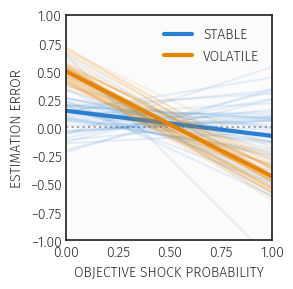

In [61]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=(3, 3), dpi=100)
plt.plot(x, np.expand_dims(betas[0, 0, :], 1).T + (np.expand_dims(betas[0, 1, :], 1) * x).T, color=pal[0], alpha=0.1);
plt.plot(x, betas[0, 0, :].mean() + betas[0, 1, :].mean() * x, color=pal[0], linewidth=3, label='STABLE');
plt.plot(x, np.expand_dims(betas[1, 0, :], 1).T + (np.expand_dims(betas[1, 1, :], 1) * x).T, color=pal[1], alpha=0.1);
plt.plot(x, betas[1, 0, :].mean() + betas[1, 1, :].mean() * x, color=pal[1], linewidth=3, label='VOLATILE');
plt.legend()
plt.axhline(0, linestyle=':', color='#a3a1a1', zorder=-10)
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.ylabel("ESTIMATION ERROR", fontweight='light')
plt.xlabel("OBJECTIVE SHOCK PROBABILITY", fontweight='light')
plt.tight_layout()
plt.savefig('../figures/estimation_error.svg', facecolor='#fbfbfb')

## Model fitting and comparison

Here we'll focus on the best fitting model (the asymettric leaky beta model) and a variant that incorporate the influence of visual attention on the **outcome** phase of the previous trial (i.e. when subjects find out the outcome of the trial). Note that this is different to the analysis of the effect of learning-related variables on attention, which focused on the **pre-outcome** phase.

Attentional effects are implemented in two ways:
* **Model 1** - update rates ($\tau$) are modulated by visual attention (the influence of which is modulated by free parameter $\gamma$), such that updates are greater for stimuli that subjects paid most attention to on the previous trial. Here $fp$ represents the fixation proportion for a given stimulus, and $\pi$ represents the calculated update weight. We additionally weight the influence of the other stimulus ($\omega$) by the time spent looking at it.

\begin{equation*}
\pi^A = \begin{matrix}
1&\text{if } fixation^A > fixation^B \\
1 - (fixation^A - fixation^B) \cdot \gamma&\text{if } fixation^A < fixation^B
\end{matrix}\\
\text{ }\\
\alpha_{t+1}^A = (1 - \lambda) \cdot \alpha_t^A + \tau^+ \cdot \pi \cdot outcome^A + \omega \cdot fixation^B \cdot outcome^B\\
\beta_{t+1}^A = (1 - \lambda) \cdot \beta_t^A + \tau^- \cdot \pi \cdot (1 - outcome^A) + \omega \cdot fixation^B \cdot (1 - outcome^B)
\end{equation*}

* **Model 2** - the aversive value of the attended stimulus is increased by adding bonus parameter $\theta$ multipled by the difference in fixation proportions between stimuli to $\alpha$. Again, we weight $\omega$ by fixation time.

\begin{equation*}
\alpha_{t+1}^A = (1 - \lambda) \cdot \alpha_t^A + \tau^+ \cdot outcome^A + \omega \cdot outcome^B + max(0,\ fixation^A - fixation^B) \cdot \theta\\
\beta_{t+1}^A = (1 - \lambda) \cdot \beta_t^A + \tau^- \cdot (1 - outcome^A) + \omega \cdot (1 - outcome^B)
\end{equation*}

These equations represent the model for stimulus $A$, the model is duplicated for stimulus $B$.

In [62]:
# Standard model
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)

# Parameters of beta distribution - starting values fixed at 1
alpha = Parameter('alpha', 'fixed', mean=1, dynamic=True)
beta = Parameter('beta', 'fixed', mean=1, dynamic=True)

# Decay rate, normally distributed between 0 and 1
decay = Parameter(r'$\lambda$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Positive and negative weights for the asymmetric model, normally distributed between 0 and 1
tau_p = Parameter(r'$\tau^+$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)
tau_n = Parameter(r'$\tau^-$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

# Influence of the other stimulus, normally distributed between 0 and 1
omega = Parameter(r'$\omega$', 'normal', lower_bound=-0.5, upper_bound=0.5, mean=0, variance=5)

leaky_beta_asymmetric_model = DMModel(leaky_beta_asymmetric, [value, alpha, beta, decay, omega, tau_p, tau_n], None, None,
                               name='Asymmetric forgetful beta nofixation', logp_function='beta')


# Fixation model 1
gamma = Parameter(r'$\gamma$', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=5)

leaky_beta_asymmetric_fixation_1_model = DMModel(leaky_beta_asymmetric_fixation_1, [value, alpha, beta, decay, omega, tau_p, tau_n, gamma], None, None,
                               name='Asymmetric forgetful beta + fixation (1)', logp_function='beta')

# Original version with binary weighting
leaky_beta_asymmetric_fixation_1b_model = DMModel(leaky_beta_asymmetric_fixation_1b, [value, alpha, beta, decay, omega, tau_p, tau_n, gamma], None, None,
                               name='Asymmetric forgetful beta + fixation (1b)', logp_function='beta')


# Fixation model 2
theta = Parameter(r'$\theta$', 'normal', lower_bound=0, upper_bound=1, mean=1, variance=5)

leaky_beta_asymmetric_fixation_2_model = DMModel(leaky_beta_asymmetric_fixation_2, [value, alpha, beta, decay, omega, tau_p, tau_n, theta], None, None,
                               name='Asymmetric forgetful beta + fixation (2)', logp_function='beta')

# Original version with binary weighting
leaky_beta_asymmetric_fixation_2b_model = DMModel(leaky_beta_asymmetric_fixation_2b, [value, alpha, beta, decay, omega, tau_p, tau_n, theta], None, None,
                               name='Asymmetric forgetful beta + fixation (2b)', logp_function='beta')

### Model fitting

We then fit each of these models. For speed this is run on a cluster, so here we just save the models and fit them using separate code (code is located at `../code/fit_behavioural_model.py`)

In [63]:
models = [leaky_beta_asymmetric_model, leaky_beta_asymmetric_fixation_1_model, leaky_beta_asymmetric_fixation_2_model, leaky_beta_asymmetric_fixation_1b_model, leaky_beta_asymmetric_fixation_2b_model]
for m in models:
    with open(os.path.join('../data/models', m.name.replace(' ', '-')), "wb") as f:
        dill.dump(m, f)

We can then reload the models after they've been fit.

In [64]:
model_dir = '../data/models'
models = []
for i in tqdm([i for i in os.listdir(model_dir) if 'Asymmetric' in i and 'fit' in i and not 'fixed' in i]):
    with open(os.path.join(model_dir, i), "rb") as f:
        models.append(dill.load(f))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.11s/it]


### Model comparison using WAIC

Comparing model fit of standard model against models including the influence of fixation during the outcome phase.

In [65]:
original_waic = models[-1].WAIC

### Continuous weighting models

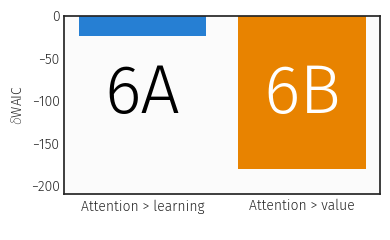

In [66]:
# Make things look nice
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = prop.get_name() + ':italic'
matplotlib.rcParams['mathtext.rm'] = prop.get_name()


models = models[:4]

# Plot the WAIC scores for each model
plt.figure(figsize=(4, 2.5), dpi=100)
waic_pal = [pal[0]] * len(models)
waics = np.array([m.WAIC - original_waic for m in models])
winning_idx = np.where(waics[::2] == waics.min())[0][0]
waic_pal[winning_idx] = pal[1]
plt.bar(['Attention > learning\n', 
         'Attention > value\n'], waics[::2], color=waic_pal)
plt.ylabel(r'$\delta$' 'WAIC', fontweight='light')
plt.ylim(waics.min() - 30, 0)
text_y = (waics.min() - 100) / 3
plt.text(0, text_y, "6A", size=50, ha='center', va='center', fontweight='light', color='#000000')
plt.text(1, text_y, "6B", size=50, ha='center', va='center', fontweight='light', color='#FFFFFF')
plt.tight_layout()

# Save the figure
plt.savefig('../figures/model_comparison_fixation_learning.svg', facecolor='#fbfbfb')


### All models

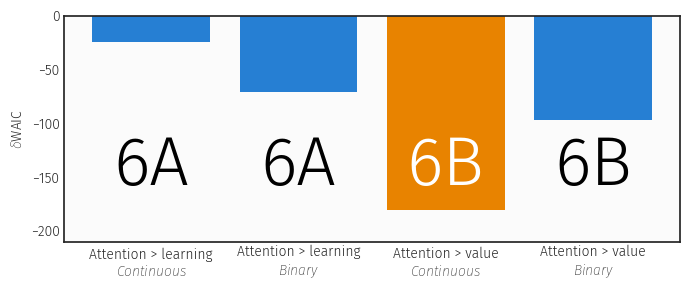

In [67]:
# Make things look nice
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = prop.get_name() + ':italic'
matplotlib.rcParams['mathtext.rm'] = prop.get_name()


models = models[:4]

# Plot the WAIC scores for each model
plt.figure(figsize=(7, 3), dpi=100)
waic_pal = [pal[0]] * len(models)
waics = np.array([m.WAIC - original_waic for m in models])
winning_idx = np.where(waics == waics.min())[0][0]
waic_pal[winning_idx] = pal[1]
plt.bar(['Attention > learning\n' r'$Continuous$', 
         'Attention > learning\n' r'$Binary$', 
         'Attention > value\n' r'$Continuous$', 
         'Attention > value\n' r'$Binary$'], waics, color=waic_pal)
plt.ylabel(r'$\delta$' 'WAIC', fontweight='light')
plt.ylim(waics.min() - 30, 0)
text_y = (waics.min() - 100) / 2
plt.text(0, text_y, "6A", size=50, ha='center', va='center', fontweight='light', color='#000000')
plt.text(1, text_y, "6A", size=50, ha='center', va='center', fontweight='light', color='#000000')
plt.text(2, text_y, "6B", size=50, ha='center', va='center', fontweight='light', color='#FFFFFF')
plt.text(3, text_y, "6B", size=50, ha='center', va='center', fontweight='light', color='#000000')
plt.tight_layout()

# Save the figure
plt.savefig('../figures/model_comparison_fixation_learning_all.svg', facecolor='#fbfbfb')


### Influence of fixation of previous trial

Looking at parameter estimates for $\theta$ can give us an idea how how much subjects' learning is influenced by attention.

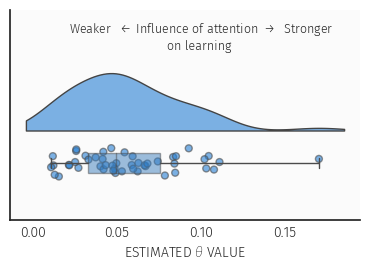

In [68]:
plt.rc('text', usetex=False)

# Get parameter values
p_table = models[2].parameter_table

# Get gamma values
theta_df = p_table[[r'mean_$\theta$', 'Subject']]
theta_df = pd.melt(theta_df, id_vars='Subject', value_vars=[i for i in theta_df.columns if 'mean' in i],
                                                        value_name='Estimated value', var_name='Parameter')
theta_df['Parameter'] = theta_df['Parameter'].str.replace('mean_', '')

# Violin plot
plt.figure(figsize=(3.8, 2.8), dpi=100)
violin = sns.violinplot(x='Estimated value', y="Parameter", data=theta_df, inner=None,
              jitter=True, color=".7", lwidth=0, width=0.6, offset=0.17, cut=1,
              linewidth=1, alpha=0.2, palette=pal, zorder=19);
for n, i in enumerate([i for i in violin.collections if isinstance(i, matplotlib.collections.PolyCollection)]):            
    plt.setp(i, facecolor=matplotlib.colors.colorConverter.to_rgba(pal[n], alpha=0.6))
    plt.setp(i, edgecolor=matplotlib.colors.colorConverter.to_rgba('#444444', alpha=1))

# Plot individual data points
sp = sns.stripplot(x='Estimated value', y="Parameter", data=theta_df, 
              jitter=0.08,
              linewidth=1, alpha=0.6, palette=pal, zorder=1);

# Boxplot
ax = sns.boxplot(x='Estimated value', y="Parameter", data=theta_df, 
                 palette=pal, whis=np.inf, linewidth=1,
           width=0.1, boxprops={"zorder":10, 'alpha':0.5}, whiskerprops={'zorder':10, 'alpha':1}, 
                 medianprops={'zorder':11, 'alpha':0.5});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.xlabel("ESTIMATED $\\theta$ VALUE", fontweight='light');

# Add text
plt.text(0.1, 0.6, "Weaker  $\leftarrow$ Influence of attention $\\rightarrow$  Stronger\non learning ", fontsize=9,
        horizontalalignment='center')

# Configure y axis
plt.yticks([])
plt.ylim([-0.3, 0.8])
plt.ylabel("")

sns.despine()
plt.tight_layout()
plt.savefig('../figures/fixation_model_theta.svg', facecolor='#fbfbfb')